# Comparing fluxes with other products




In [1]:
import datetime
import numpy as np
import xarray as xr
import rioxarray as rxr
import pyproj

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

import matplotlib 
matplotlib.rcParams.update({'font.size': 16})

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
var = 'NEE'
var_fc = 'nee'
results_name = 'NEE_2003_2021_5km_LGBM.nc'
upper = 'NEE_2003_2021_5km_LGBM_upper.nc'
lower = 'NEE_2003_2021_5km_LGBM_lower.nc'

## Open various datasets

In [3]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

ds_upper = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+upper)
ds_upper.attrs['nodata'] = np.nan

ds_lower = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+lower)
ds_lower.attrs['nodata'] = np.nan

### Fluxcom

In [4]:
ds_fc = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/FLUXCOM/'+var_fc+'_rs_meteo_era5.nc').sel(time=slice('2003', '2018')), crs='epsg:4326')
ds_fc = ds_fc.rename({'lat':'latitude', 'lon':'longitude'})
ds_fc.attrs['nodata'] = np.nan
ds_fc['latitude'] = ds_fc.latitude.astype('float32')
ds_fc['longitude'] = ds_fc.longitude.astype('float32')

### MODIS GPP

In [ ]:
modis_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/1km/MODIS_GPP_1km_monthly_2002_2021.nc')
modis_gpp.attrs['nodata'] = np.nan

### GOSIF GPP

In [ ]:
gosif_gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/GOSIF_GPP_5km_monthly_2002_2021.nc')
gosif_gpp.attrs['nodata'] = np.nan

In [ ]:
# evi=xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/5km/EVI_5km_monthly_2002_2021.nc')

### Villalobos et al 

Needed to fix the dataset before it could be opened. Used the R script in data/villalobos/

In [5]:
fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/post.tif'
post = rxr.open_rasterio(fn).rename({'band':'month'})
post['month']=ds.sel(time=slice('2015', '2019')).time.values
post = post.rename({'month':'time'})
post = xr_reproject(post, geobox=post.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
post.attrs['nodata'] = np.nan
post.attrs['units'] = 'PgC/year'

fn = '/g/data/os22/chad_tmp/NEE_modelling/data/villalobos/land.tif'
cable = rxr.open_rasterio(fn).rename({'band':'month'})
cable['month']=ds.sel(time=slice('2015', '2019')).time.values
cable = cable.rename({'month':'time'})
cable = xr_reproject(cable, geobox=cable.odc.geobox.to_crs('epsg:3577').compat, resampling='nearest')
# post = assign_crs(post, crs='epsg:3577')
cable.attrs['nodata'] = np.nan
cable.attrs['units'] = 'PgC/year'

# create a mask for this janky dataset
mask_inv = cable.where(cable==0).isel(time=1)
mask_inv = mask_inv.astype(bool)

post = post.where(mask_inv)
cable = cable.where(mask_inv)

## Define a common grid

Resolution is similar to Villalobos as that's the coarest product

In [6]:
grid = zoom_out(ds.odc.geobox, 15)

In [7]:
grid = grid.to_crs('EPSG:3577')

In [ ]:
grid

### Reproject datasets to match common grid

In [8]:
ds = xr_reproject(ds, geobox=grid.compat, resampling='average')
ds_upper = xr_reproject(ds_upper, geobox=grid.compat, resampling='average')
ds_lower = xr_reproject(ds_lower, geobox=grid.compat, resampling='average')

mask = np.isnan(ds.isel(time=1))

In [9]:
ds_fc = xr_reproject(ds_fc, geobox=grid.compat, resampling='average')
ds_fc = ds_fc[var].where(~mask.astype(bool))
ds_fc = ds_fc*30 #/day to /month

In [10]:
post = xr_reproject(post, geobox=grid.compat, resampling='bilinear')
cable = xr_reproject(cable, geobox=grid.compat, resampling='bilinear')

In [ ]:
modis_gpp = xr_reproject(modis_gpp, geobox=grid.compat, resampling='average')

modis_gpp = modis_gpp.where(~mask.astype(bool))

In [ ]:
gosif_gpp = xr_reproject(gosif_gpp, geobox=grid.compat, resampling='average')

gosif_gpp = gosif_gpp.where(~mask.astype(bool))

In [ ]:
# evi=xr_reproject(evi, geobox=grid.geobox, resampling='average')
# evi=evi.where(~mask.astype(bool))

## Convert to total C in (petagrams) rather than gC/m2

Find area of pixels

In [11]:
area_per_pixel = ds.geobox.resolution[1]**2

ds = ds * area_per_pixel * 1e-15
ds = ds*12 #convert to Pg/Year (even though monthly timeseries)

ds_upper = ds_upper * area_per_pixel * 1e-15
ds_upper = ds_upper*12 

ds_lower = ds_lower * area_per_pixel * 1e-15
ds_lower = ds_lower*12 

ds_fc = ds_fc * area_per_pixel * 1e-15
ds_fc = ds_fc*12

In [ ]:
modis_gpp = modis_gpp * area_per_pixel * 1e-12
gosif_gpp = gosif_gpp * area_per_pixel * 1e-15

## Plot time-series and find annual mean and std dev 

In [ ]:
trim=False

In [ ]:
if trim:
    ds = ds.sel(time=slice('2015', '2019'))
    ds_fc = ds_fc.sel(time=slice('2015', '2019'))

In [12]:
ds_1d = ds.sum(['x', 'y'])
ds_1d_upper = ds_upper.sum(['x', 'y'])
ds_1d_lower = ds_lower.sum(['x', 'y'])
ds_fc_1d = ds_fc.sum(['x', 'y'])
post_1d = post.sum(['x', 'y'])
cable_1d = cable.sum(['x', 'y'])

In [13]:
print(f'Mean of this study: {ds_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of this study: {ds_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Fluxcom: {ds_fc_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Fluxcom: {ds_fc_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Inversion: {post_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Inversion: {post_1d.std().values:.3f} PgC/yr')
print('\n')
print(f'Mean of Cable: {cable_1d.mean().values:.3f} PgC/yr')
print(f'Std Dev of Cable: {cable_1d.std().values:.3f} PgC/yr')

Mean of this study: -0.683 PgC/yr
Std Dev of this study: 0.455 PgC/yr


Mean of Fluxcom: -0.096 PgC/yr
Std Dev of Fluxcom: 0.295 PgC/yr


Mean of Inversion: -0.455 PgC/yr
Std Dev of Inversion: 1.134 PgC/yr


Mean of Cable: -0.003 PgC/yr
Std Dev of Cable: 0.394 PgC/yr


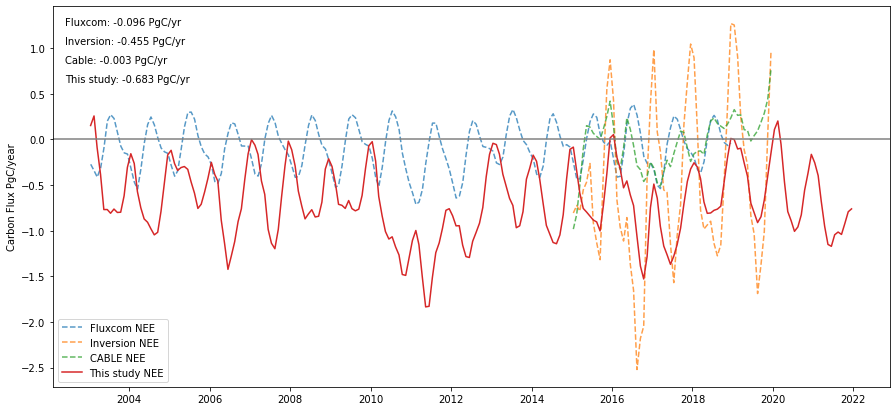

In [14]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_fc_1d.time.values, ds_fc_1d.rolling(time=3, min_periods=1).mean(), linestyle='--', label='Fluxcom '+var, alpha=0.75)
# ax.plot(modis_gpp_1D.time.values, modis_gpp_1D, linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(post_1d.time.values, post_1d.rolling(time=3, min_periods=1).mean(), linestyle='--', label='Inversion '+var, alpha=0.75)
ax.plot(cable_1d.time.values, cable_1d.rolling(time=3, min_periods=1).mean(), linestyle='--', label='CABLE '+var, alpha=0.75)
ax.plot(ds_1d.time.values, ds_1d.rolling(time=3, min_periods=1).mean(),  label='This study '+var)
# ax.plot(ds_1d_upper.time.values, ds_1d_upper.rolling(time=3, min_periods=1).mean(),  label='This study upper '+var)
# ax.plot(ds_1d_lower.time.values, ds_1d_lower.rolling(time=3, min_periods=1).mean(),  label='This study lower '+var)

plt.axhline(0, c='grey')
ax.legend(loc='lower left')
ax.set_ylabel('Carbon Flux PgC/year');
ax.text(.015, .95, f'Fluxcom: {ds_fc_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)
ax.text(.015, .90, f'Inversion: {post_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)
ax.text(.015, .85, f'Cable: {cable_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes)
ax.text(.015, .80, f'This study: {ds_1d.mean().values:.3f} PgC/yr',
        transform=ax.transAxes);


# ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2019, 12, 31)])
# ax.set_ylim(-2.5, 2.5)


## Convert to anomalies

### Climatology

In [15]:
import warnings
warnings.filterwarnings("ignore")

ds_clim_mean = ds.groupby('time.month').mean()
ds_clim_mean_annual = ds.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

ds_fc_clim_mean = ds_fc.groupby('time.month').mean()
ds_fc_clim_mean_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

post_clim_mean = post.groupby('time.month').mean()
post_clim_mean_annual = post.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

cable_clim_mean = cable.groupby('time.month').mean()
cable_clim_mean_annual = cable.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

In [ ]:
modis_gpp_clim_mean = modis_gpp.groupby('time.month').mean()
modis_gpp_clim_mean_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

gosif_gpp_clim_mean = gosif_gpp.groupby('time.month').mean()
gosif_gpp_clim_mean_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum().mean('time')

### Anomalies

In [ ]:
ds_anom = (ds.groupby('time.month') - ds_clim_mean)
ds_fc_anom = (ds_fc.groupby('time.month') - ds_fc_clim_mean)
post_anom = (post.groupby('time.month') - post_clim_mean)
cable_anom = (cable.groupby('time.month') - cable_clim_mean)

ds_anom_annual = ds.resample(time='1Y', label='left', loffset='6M').sum() - ds_clim_mean_annual
ds_fc_anom_annual = ds_fc.resample(time='1Y', label='left', loffset='6M').sum() - ds_fc_clim_mean_annual
post_anom_annual = post.resample(time='1Y', label='left', loffset='6M').sum() - post_clim_mean_annual
cable_anom_annual = cable.resample(time='1Y', label='left', loffset='6M').sum() - cable_clim_mean_annual



In [ ]:
modis_gpp_anom = (modis_gpp.groupby('time.month') - modis_gpp_clim_mean)
gosif_gpp_anom = (gosif_gpp.groupby('time.month') - gosif_gpp_clim_mean)

modis_gpp_anom_annual = modis_gpp.resample(time='1Y', label='left', loffset='6M').sum() - modis_gpp_clim_mean_annual
gosif_gpp_anom_annual = gosif_gpp.resample(time='1Y', label='left', loffset='6M').sum() - gosif_gpp_clim_mean_annual

## Zonal summaries

### Monthly

In [ ]:
ds_1D = ds_anom.sum(['x','y'])
ds_fc_1D = ds_fc_anom.sum(['x','y'])
post_1D = post_anom.sum(['latitude','longitude'])
cable_1D = cable_anom.sum(['latitude','longitude'])

In [ ]:
modis_gpp_1D = modis_gpp_anom.sum(['x','y'])
gosif_gpp_1D = gosif_gpp_anom.sum(['x','y'])

In [ ]:
# if trim:
#     ds = ds.sel(time=slice('2015', '2019'))
#     ds_fc = ds.sel(time=slice('2015', '2019'))

fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_fc_1D.time.values, ds_fc_1D.rolling(time=3, min_periods=1).mean(), linestyle='--', label='Fluxcom '+var, alpha=0.75)
ax.plot(post_1D.time.values, post_1D.rolling(time=3, min_periods=1).mean(), linestyle='--', label='Inversion '+var, alpha=0.75)
ax.plot(cable_1D.time.values, cable_1D.rolling(time=3, min_periods=1).mean(), linestyle='--', label='Cable '+var, alpha=0.75)
# ax.plot(modis_gpp_1D.time.values, modis_gpp_1D, linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(gosif_gpp_1D.time.values, gosif_gpp_1D, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(ds_1D.time.values, ds_1D.rolling(time=3, min_periods=1).mean(),  label='This study '+var)
ax.legend(loc='lower left')
ax.set_ylabel('Carbon Flux Anomaly PgC/year');
# ax.set_ylim(-0.175, 0.175)
# ax.text(.015, .95, f'Fluxcom: {ds_fc_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .90, f'Inversion: {post_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .85, f'Cable: {cable_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes)
# ax.text(.015, .80, f'This study: {ds_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes);
# ax2=ax.twinx()
# # ax2.plot(evi_1D.time.values, evi_1D, label='MODIS-EVI', color='c', )
# ax2.legend(loc='upper right')
# ax2.set_ylim(-0.05, 0.05)
# ax2.set_ylabel('EVI Anomaly');

plt.axhline(0, c='grey');
# plt.title(var);



### Annual

In [ ]:
ds_1D_annual = ds_anom_annual.sum(['x','y'])
ds_fc_1D_annual = ds_fc_anom_annual.sum(['x','y'])

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(ds_fc_1D_annual.time.values, ds_fc_1D_annual, linestyle='--', label='Fluxcom ' +var, alpha=0.75)
# ax.plot(modis_gpp_annual.time.values, modis_gpp_annual,linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(gosif_gpp_annual.time.values, gosif_gpp_annual, linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(ds_1D_annual.time.values, ds_1D_annual, label='This study '+var)
# ax.set_ylim(-1.1, 1.1)
ax.legend(loc='upper left')
ax.set_ylabel('Carbon Flux Anomaly PgC/year')
plt.axhline(0, c='grey');

# ax2=ax.twinx()
# ax2.plot(evi_annual.time.values, evi_annual, marker='o', linestyle='--', label='MODIS-EVI', color='c')
# ax2.legend(loc='upper left')
# ax2.set_ylabel('EVI Anomaly');

## Month of maximum flux

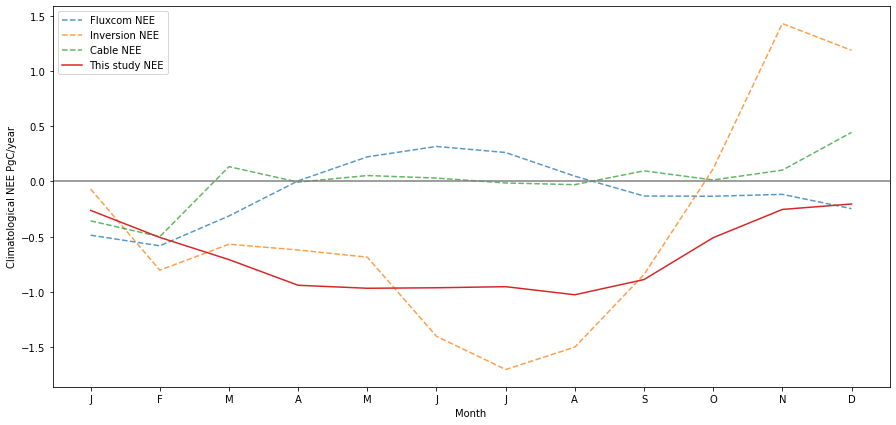

In [16]:
y = ds_clim_mean.where(~mask).sum(['x','y']).values
x = ds_clim_mean.month.values

y_fc = ds_fc_clim_mean.where(~mask).sum(['x','y']).values
x_fc = ds_fc_clim_mean.month.values

y_post = post_clim_mean.sum(['x','y']).values
x_post = post_clim_mean.month.values

y_cable = cable_clim_mean.sum(['x','y']).values
x_cable = cable_clim_mean.month.values

# y_modis_gpp = modis_gpp_clim_mean.where(~mask).sum(['x','y']).values
# x_modis_gpp = modis_gpp_clim_mean.month.values

# y_gosif_gpp = gosif_gpp_clim_mean.where(~mask).sum(['x','y']).values
# x_gosif_gpp = gosif_gpp_clim_mean.month.values

fig,ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(x_fc, y_fc, linestyle='--', label='Fluxcom '+var, alpha=0.75)
ax.plot(x_post, y_post, linestyle='--', label='Inversion '+var, alpha=0.75)
ax.plot(x_cable, y_cable, linestyle='--', label='Cable '+var, alpha=0.75)
# ax.plot(x_modis_gpp, y_modis_gpp,  linestyle='--', label='MODIS '+var, alpha=0.75)
# ax.plot(x_gosif_gpp, y_gosif_gpp,  linestyle='--', label='GOSIF '+var, alpha=0.75)
ax.plot(x, y, label='This study '+var)

ax.axhline(0, c='grey')

# ax.fill_between(x_fc, y_fc-std_fc, y_fc+std_fc, alpha=0.5)
# ax.fill_between(x, y-std, y+std, alpha=0.5)

ax.legend(loc='upper left')
# ax.set_title(var+' Climatology')
ax.set_xlabel('Month')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"])             
ax.set_ylabel('Climatological '+var+' PgC/year');


In [17]:
if var == 'NEE':
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'min')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'min')
    max_mean_month_post = allNaN_arg(post_clim_mean, 'month', 'min')
    max_mean_month_cable = allNaN_arg(cable_clim_mean, 'month', 'min')
    # max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'min')
    # max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'min')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(ds_clim_mean, 'month', 'max')
    max_mean_month_fc = allNaN_arg(ds_fc_clim_mean, 'month', 'max')
    max_mean_month_modis = allNaN_arg(modis_gpp_clim_mean, 'month', 'max')
    max_mean_month_gosif = allNaN_arg(gosif_gpp_clim_mean, 'month', 'max')
    #max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

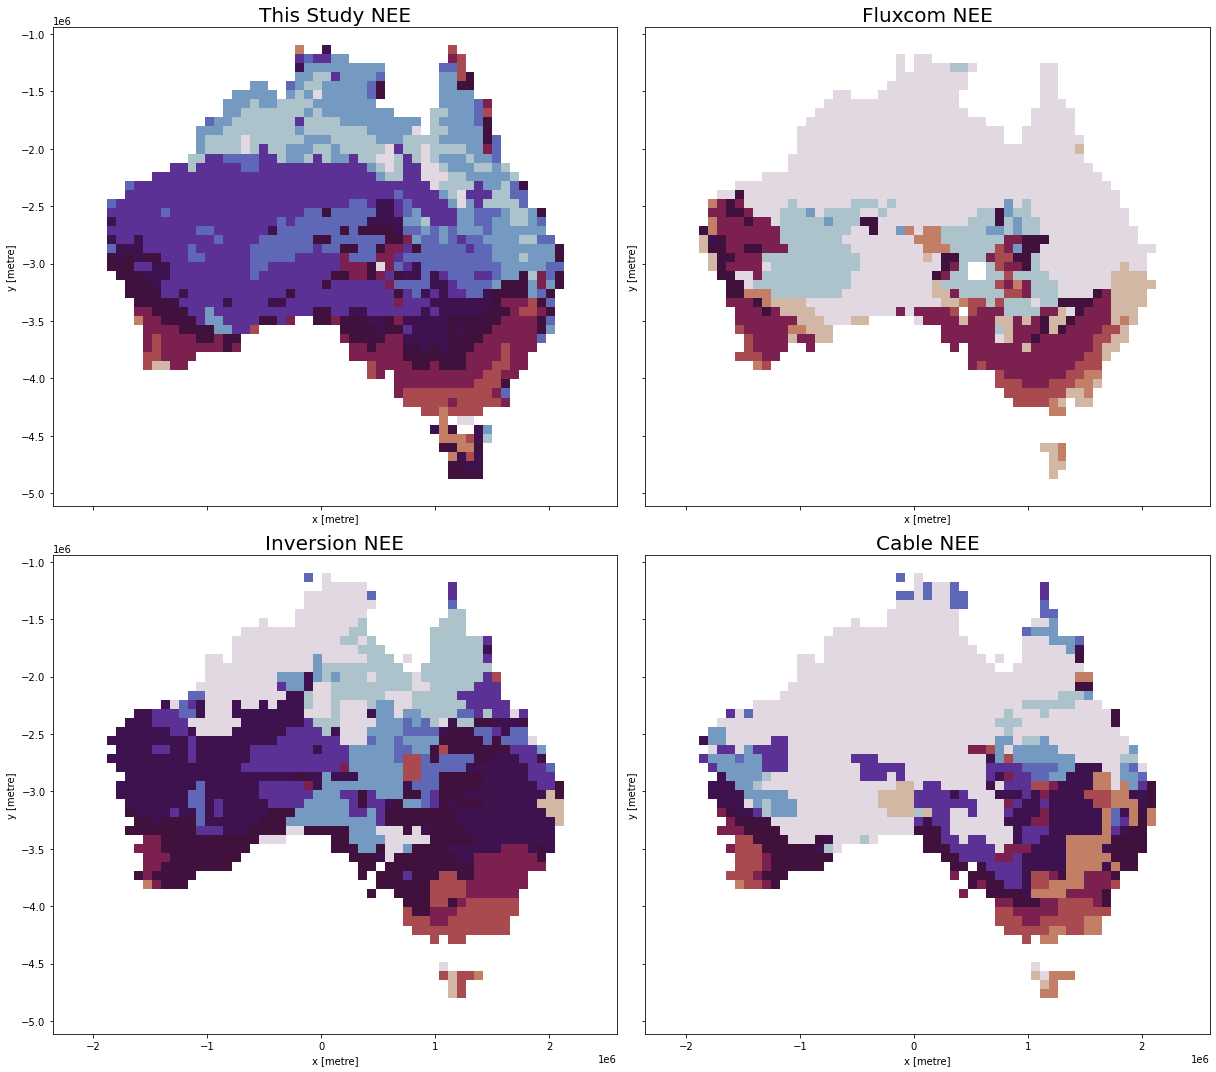

In [19]:
fig,ax = plt.subplots(2,2, figsize=(17,15), sharey=True, sharex=True)

im = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0,0], cmap='twilight', add_colorbar=False)
ax[0,0].set_title('This Study '+var, fontsize=20);

im = max_mean_month_fc.plot.imshow(vmin=1, vmax=12, ax=ax[0,1], cmap='twilight', add_colorbar=False)
ax[0,1].set_title('Fluxcom '+var, fontsize=20);

im = max_mean_month_post.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False)
ax[1,0].set_title('Inversion '+var, fontsize=20);

im = max_mean_month_cable.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
ax[1,1].set_title('Cable '+var, fontsize=20);

# im = max_mean_month_modis.plot.imshow(vmin=1, vmax=12, ax=ax[1,0], cmap='twilight', add_colorbar=False)
# ax[1,0].set_title('MODIS '+var, fontsize=20);

# im = max_mean_month_gosif.plot.imshow(vmin=1, vmax=12, ax=ax[1,1], cmap='twilight', add_colorbar=False)
# ax[1,1].set_title('GOSIF '+var, fontsize=20);

# cbar = fig.colorbar(im, spacing='uniform', ax=ax.ravel().tolist(), orientation='horizontal', shrink=0.4)
# cbar.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
# cbar.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=20)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/month_of_max_'+var+'.png')
